In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
from sklearn.metrics import r2_score, explained_variance_score
from scipy.stats import pearsonr

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [39]:
btc_file = '../knn/Bitcoin_01.10.2017-20.03.2025_historical_data_coinmarketcap.csv'
eth_file = '../knn/Ethereum_01.12.2018-28.02.2025_historical_data_coinmarketcap.csv'
Uah_file = '../knn/Official hrivnya exchange rates.csv'

df_btc = pd.read_csv(btc_file, sep=';')
df_eth = pd.read_csv(eth_file, sep=';')
df_uah = pd.read_csv(Uah_file, sep=',')


feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# scaled_df = df_btc.copy()
df = df_uah.copy()
# Видаляємо пробіли й лапки з назв колонок
df.columns = df.columns.str.strip().str.replace('"', '')
print(df.columns.tolist())


df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

df_cleaned = df[['Year', 'Month', 'Day', 'Official hrivnya exchange rates, UAH']].copy()

scaled_df = df_cleaned.copy()
target_col = 'Official hrivnya exchange rates, UAH'
scaled_df[target_col] = feature_scaler.fit_transform(scaled_df[[target_col]])

['Date', 'Time', 'Digital code', 'Letter code', 'Unit', 'Currency name', 'Official hrivnya exchange rates, UAH']


In [40]:
# columns_to_drop = ['timeOpen', 'timeClose', 'timeHigh', 'timeLow']
# for col in columns_to_drop:
#     if col in scaled_df.columns:
#         scaled_df.drop(columns=[col], inplace=True)

# if 'timestamp' in scaled_df.columns:
#     scaled_df = scaled_df.set_index('timestamp')

# feature_columns = ['open', 'high', 'low', 'volume', 'marketCap']
# target_column = 'close'

# available_feature_cols = [col for col in feature_columns if col in scaled_df.columns]
# print(f"Доступні колонки для features: {available_feature_cols}")

# if target_column not in scaled_df.columns:
#     print(f"Помилка: колонка '{target_column}' не знайдена!")
#     exit()

# scaled_df[available_feature_cols] = feature_scaler.fit_transform(scaled_df[available_feature_cols])
# scaled_df[[target_column]] = target_scaler.fit_transform(scaled_df[[target_column]])

# print("Структура даних:")
# print(scaled_df.head())
# print(f"Shape: {scaled_df.shape}")

In [41]:
def prepare_data(df, window_size=5, target_col='Official hrivnya exchange rates, UAH'):
    X, y = [], []
    feature_cols = [col for col in df.columns if col != target_col]
    
    for i in range(len(df) - window_size):
        features = df[feature_cols].iloc[i:i+window_size].values
        target = df[target_col].iloc[i+window_size]
        
        X.append(features.flatten())
        y.append(target)
    
    return np.array(X), np.array(y)


In [42]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2=None, dropout_rate=0.2):
        super(MLPModel, self).__init__()
        
        layers = []
        layers.append(nn.Linear(input_size, hidden_size1))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        
        if hidden_size2:
            layers.append(nn.Linear(hidden_size1, hidden_size2))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            layers.append(nn.Linear(hidden_size2, 1))
        else:
            layers.append(nn.Linear(hidden_size1, 1))
            
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [43]:
def run_torch_model_with_save(model_name, model, X_train, y_train, X_test, y_test, 
                             target_scaler, results_dict, epochs=100, lr=0.001):
    print(f"Training {model_name}...")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    
    model = model.to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")
    
    model.eval()
    with torch.no_grad():
        preds = model(X_test_tensor).cpu().numpy()
    
    preds_inv = target_scaler.inverse_transform(preds)
    y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_inv, preds_inv))
    mae = mean_absolute_error(y_test_inv, preds_inv)
    
    results_dict[model_name] = {
        'RMSE': rmse,
        'MAE': mae,
        'final_loss': train_losses[-1],
        'model': model,  
        'X_test': X_test,
        'y_test': y_test
    }
    
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    print("-" * 50)
    
    return model

In [44]:
results = {}

window_sizes = [5, 10, 15]
hidden_sizes = [(64,), (128,), (64, 32), (128, 64), (256, 128)]
learning_rates = [0.001, 0.01]
epochs_list = [50, 100, 1000]

best_X_test, best_y_test = None, None

print("Початок експериментів з MLP моделями")
print("=" * 60)

experiment_count = 0
total_experiments = len(window_sizes) * len(hidden_sizes) * len(learning_rates) * len(epochs_list)


Початок експериментів з MLP моделями


In [45]:
for window_size in window_sizes:
    print(f"\n Window size: {window_size}")
    
    X, y = prepare_data(scaled_df, window_size=window_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
    
    # Скейлимо таргет
    target_scaler = MinMaxScaler()
    y_train = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test = target_scaler.transform(y_test.reshape(-1, 1)).flatten()
    
    best_X_test, best_y_test = X_test, y_test
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    input_size = X_train.shape[1]
    
    for hidden_config in hidden_sizes:
        for lr in learning_rates:
            for epochs in epochs_list:
                experiment_count += 1

                if len(hidden_config) == 1:
                    model = MLPModel(input_size=input_size, 
                                   hidden_size1=hidden_config[0])
                    model_name = f"MLP_w{window_size}_h{hidden_config[0]}_lr{lr}_e{epochs}"
                else:
                    model = MLPModel(input_size=input_size, 
                                   hidden_size1=hidden_config[0],
                                   hidden_size2=hidden_config[1])
                    model_name = f"MLP_w{window_size}_h{hidden_config[0]}-{hidden_config[1]}_lr{lr}_e{epochs}"
                
                print(f"\n[{experiment_count}/{total_experiments}] {model_name}")
                
                run_torch_model_with_save(model_name, model, X_train, y_train, X_test, y_test, 
                              target_scaler, results, epochs=epochs, lr=lr)



 Window size: 5
Training set shape: (12439, 15)
Test set shape: (3110, 15)

[1/90] MLP_w5_h64_lr0.001_e50
Training MLP_w5_h64_lr0.001_e50...
Epoch 20/50, Loss: 18789.228516
Epoch 40/50, Loss: 11662.357422
RMSE: 10.2090, MAE: 9.9040
--------------------------------------------------

[2/90] MLP_w5_h64_lr0.001_e100
Training MLP_w5_h64_lr0.001_e100...
Epoch 20/100, Loss: 19238.746094
Epoch 40/100, Loss: 10442.385742
Epoch 60/100, Loss: 8785.829102
Epoch 80/100, Loss: 7743.270508
Epoch 100/100, Loss: 6662.641113
RMSE: 2.1482, MAE: 1.8083
--------------------------------------------------

[3/90] MLP_w5_h64_lr0.001_e1000
Training MLP_w5_h64_lr0.001_e1000...
Epoch 20/1000, Loss: 9678.778320
Epoch 40/1000, Loss: 5913.441406
Epoch 60/1000, Loss: 3614.705566
Epoch 80/1000, Loss: 2187.137939
Epoch 100/1000, Loss: 1383.120239
Epoch 120/1000, Loss: 905.996033
Epoch 140/1000, Loss: 593.347961
Epoch 160/1000, Loss: 398.643768
Epoch 180/1000, Loss: 267.932312
Epoch 200/1000, Loss: 186.906067
Epoch 2

In [46]:
sorted_results = sorted(results.items(), key=lambda x: x[1]['RMSE'])

print(f"{'Model Name':<40} {'RMSE':<10} {'MAE':<10} {'Final Loss':<12}")
print("-" * 80)

for model_name, metrics in sorted_results:
    rmse = metrics['RMSE']
    mae = metrics['MAE']
    final_loss = metrics['final_loss']
    print(f"{model_name:<40} {rmse:<10.4f} {mae:<10.4f} {final_loss:<12.6f}")

best_model = sorted_results[0]
print(f"\n НАЙКРАЩА МОДЕЛЬ: {best_model[0]}")
print(f"   RMSE: {best_model[1]['RMSE']:.4f}")
print(f"   MAE: {best_model[1]['MAE']:.4f}")

print(f"\n АНАЛІЗ ПО WINDOW SIZE:")
for ws in window_sizes:
    ws_results = [(name, metrics) for name, metrics in results.items() if f"_w{ws}_" in name]
    if ws_results:
        best_ws = min(ws_results, key=lambda x: x[1]['RMSE'])
        avg_rmse = np.mean([metrics['RMSE'] for _, metrics in ws_results])
        print(f"Window {ws}: Найкращий RMSE = {best_ws[1]['RMSE']:.4f}, Середній RMSE = {avg_rmse:.4f}")

Model Name                               RMSE       MAE        Final Loss  
--------------------------------------------------------------------------------
MLP_w15_h64-32_lr0.01_e1000              0.3557     0.3391     0.281165    
MLP_w5_h128-64_lr0.001_e1000             0.3560     0.3452     0.105517    
MLP_w15_h128-64_lr0.01_e100              0.3562     0.3358     1.061748    
MLP_w10_h64-32_lr0.001_e1000             0.3570     0.3331     0.442143    
MLP_w5_h64-32_lr0.001_e1000              0.3573     0.3313     1.790764    
MLP_w5_h64_lr0.01_e1000                  0.3584     0.3485     0.076660    
MLP_w10_h64-32_lr0.01_e100               0.3588     0.3539     0.637127    
MLP_w10_h128_lr0.01_e1000                0.3592     0.3464     0.122561    
MLP_w5_h64-32_lr0.01_e1000               0.3597     0.3257     0.175963    
MLP_w10_h64_lr0.001_e1000                0.3598     0.3492     0.081813    
MLP_w5_h256-128_lr0.001_e1000            0.3600     0.3256     0.685358    
MLP_w5_

In [47]:
# def run_complete_analysis(df, feature_scaler, target_scaler, best_model, 
#                          X_test, y_test, model_name):
#     """
#     Запуск повного аналізу моделі
#     """
#     print("🚀 ПОЧАТОК ПОВНОГО АНАЛІЗУ МОДЕЛІ")
#     print("=" * 60)
    
#     # Ініціалізація аналізатора
#     analyzer = ModelAnalyzer(df, feature_scaler, target_scaler)
    
#     # 1. Аналіз кореляцій
#     correlation_matrix = analyzer.analyze_correlations()
    
#     # 2. Розподіл ознак
#     analyzer.create_feature_distributions()
    
#     # 3. Детальний аналіз найкращої моделі
#     # results = analyzer.analyze_best_model(best_model, X_test, y_test, model_name)
    
#     # 4. Аналіз важливості ознак
#     feature_names = [f'Feature_{i}' for i in range(X_test.shape[1])]
#     analyzer.create_feature_importance_analysis(best_model, X_test, feature_names)
    
#     print(f"\n✅ АНАЛІЗ ЗАВЕРШЕНО!")
#     print("=" * 60)
    
#     return analyzer, results

# # Приклад використання (додайте це до основного коду):

# # Після навчання всіх моделей та визначення найкращої:
# best_model_name = sorted_results[0][0]  # Назва найкращої моделі
# # Тут потрібно зберегти саму модель під час навчання та передати її сюда

# # Запуск аналізу
# analyzer, analysis_results = run_complete_analysis(
#     df=scaled_df,
#     feature_scaler=feature_scaler, 
#     target_scaler=target_scaler,
#     best_model=best_model[0],  
#     X_test=X_test,
#     y_test=y_test,
#     model_name=best_model_name
# )


--------------------
ПОЧАТОК ДЕТАЛЬНОГО АНАЛІЗУ НАЙКРАЩОЇ МОДЕЛІ
--------------------
 ПОЧАТОК ПОВНОГО АНАЛІЗУ МОДЕЛІ
 АНАЛІЗ КОРЕЛЯЦІЇ ОЗНАК (ПІРСОН)


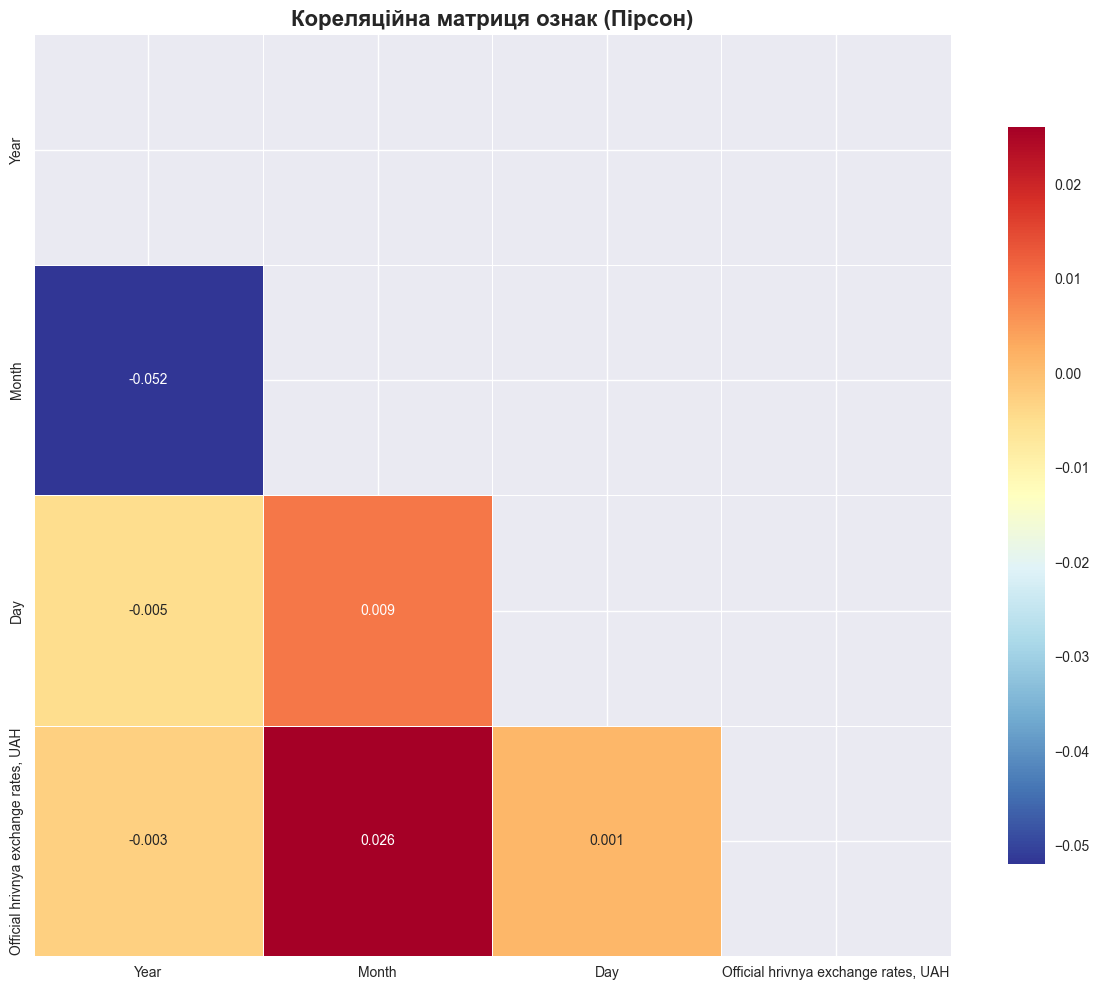


 Найсильніші кореляції:
 1. Year         ↔ Month       : -0.052
 2. Month        ↔ Official hrivnya exchange rates, UAH:  0.026
 3. Month        ↔ Day         :  0.009
 4. Year         ↔ Day         : -0.005
 5. Year         ↔ Official hrivnya exchange rates, UAH: -0.003
 6. Day          ↔ Official hrivnya exchange rates, UAH:  0.001

 РОЗПОДІЛ ОЗНАК


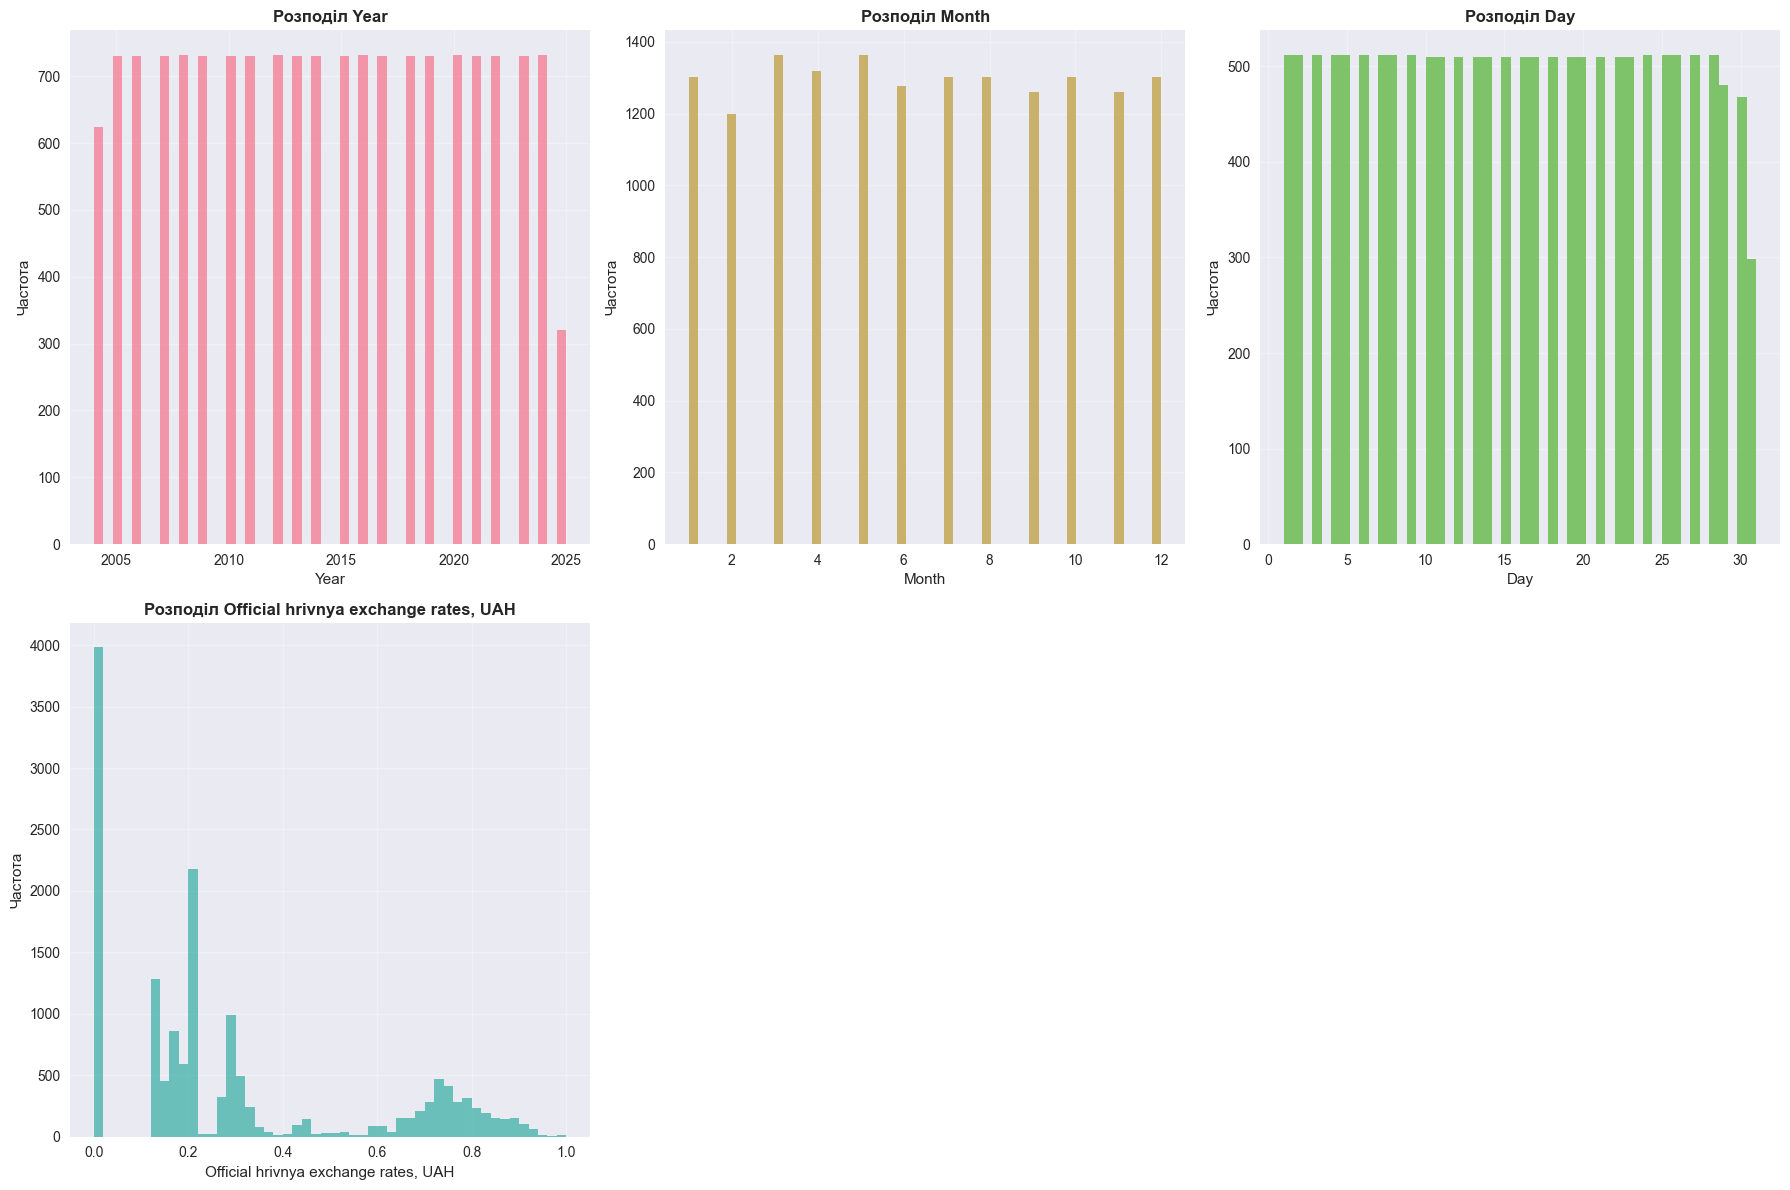


 ДЕТАЛЬНИЙ АНАЛІЗ НАЙКРАЩОЇ МОДЕЛІ: MLP_w15_h64-32_lr0.01_e1000
 МЕТРИКИ РЕГРЕСІЇ:
RMSE (Root Mean Square Error): 0.3557
MAE (Mean Absolute Error): 0.3391
MAPE (Mean Absolute Percentage Error): inf%
R² Score: -0.0008
Explained Variance Score: -0.0005


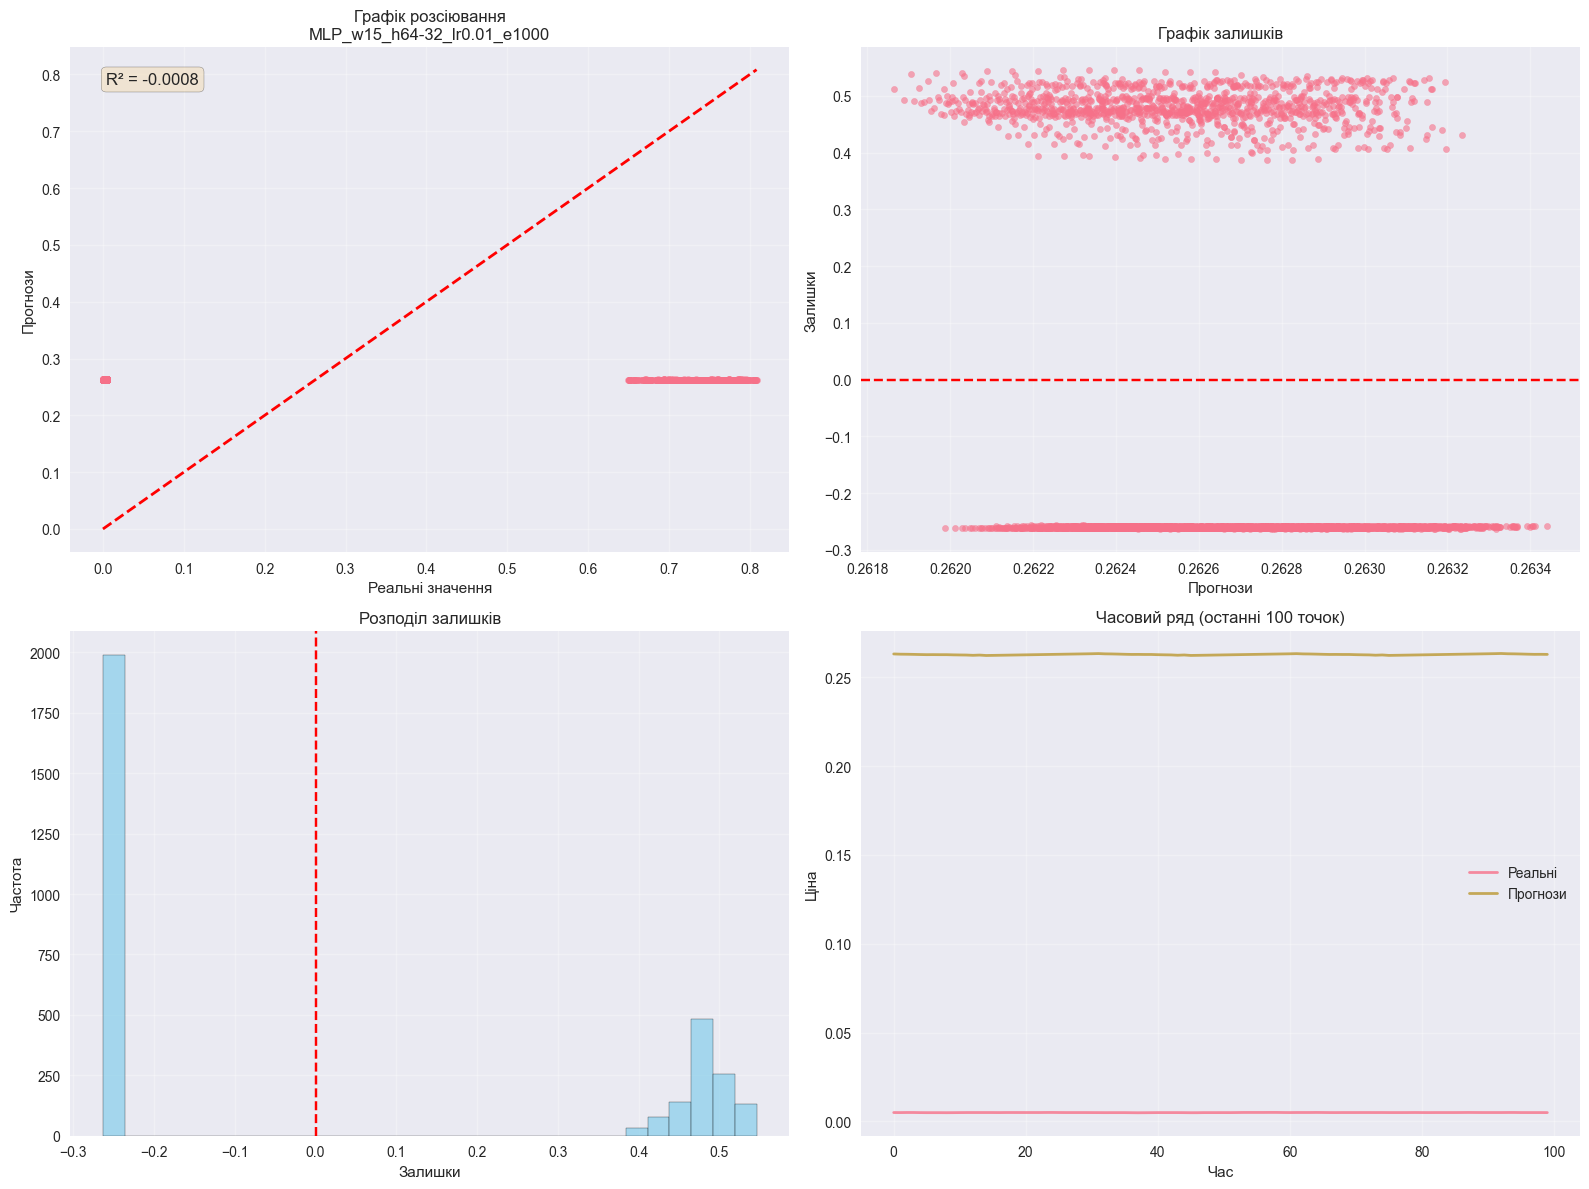


 КЛАСИФІКАЦІЙНІ МЕТРИКИ (Напрямок руху ціни):
Класи: 0 = Спадання, 1 = Зростання
Accuracy: 0.4593
Precision: 0.6181
Recall: 0.4593
F1-Score: 0.4796

 Детальний класифікаційний звіт:
              precision    recall  f1-score   support

    Спадання       0.74      0.39      0.51      2257
   Зростання       0.28      0.64      0.39       850

    accuracy                           0.46      3107
   macro avg       0.51      0.52      0.45      3107
weighted avg       0.62      0.46      0.48      3107



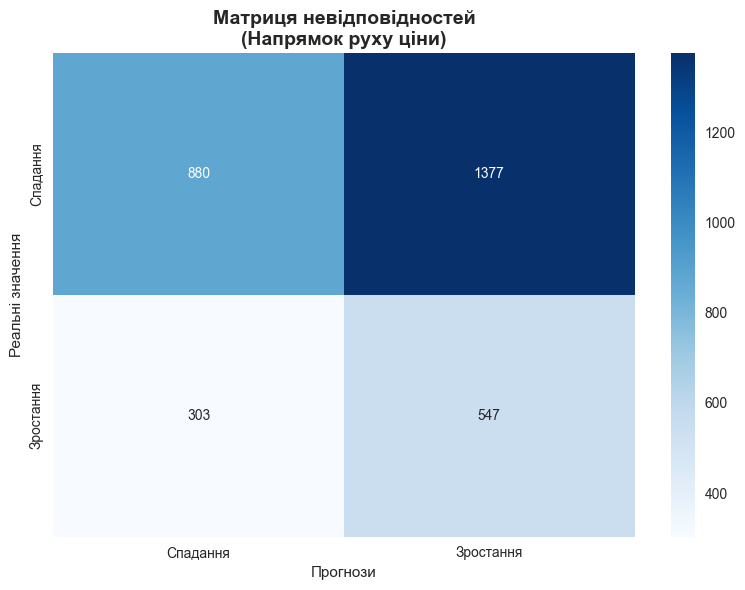


 Інтерпретація матриці невідповідностей:
True Negatives (правильно передбачені спадання): 880
False Positives (помилково передбачені зростання): 1377
False Negatives (пропущені зростання): 303
True Positives (правильно передбачені зростання): 547

 ТАБЛИЦЯ ПОРІВНЯННЯ МЕТРИК:
Метрика      Значення   Опис                                    
-----------------------------------------------------------------
Accuracy     0.4593     Частка правильних прогнозів             
Precision    0.6181     Частка правильних позитивних прогнозів  
Recall       0.4593     Частка знайдених позитивних випадків    
F1-Score     0.4796     Гармонічне середнє Precision і Recall   


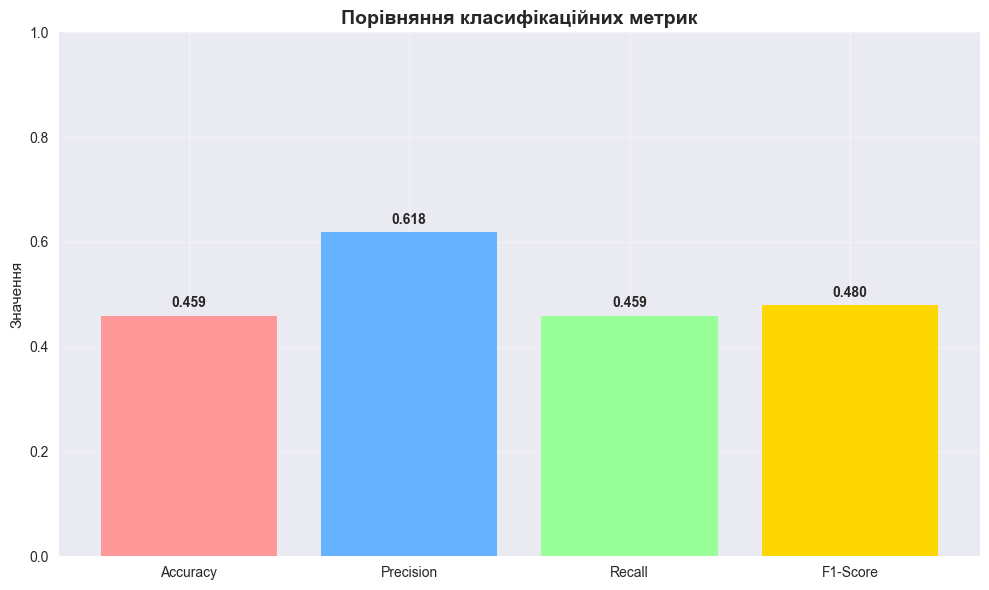


 АНАЛІЗ ВАЖЛИВОСТІ ОЗНАК
 Статистика параметрів моделі:
Загальна кількість параметрів: 5,057
Навчальні параметри: 5,057

 Статистика вхідних ознак:
       Feature       Mean     Std   Min   Max
0    Feature_0  2020.6515  2.4749  2016  2025
1    Feature_1     6.4244  3.4969     1    12
2    Feature_2    15.7339  8.7943     1    31
3    Feature_3  2020.6544  2.4748  2016  2025
4    Feature_4     6.4225  3.4960     1    12
5    Feature_5    15.7355  8.7957     1    31
6    Feature_6  2020.6573  2.4746  2016  2025
7    Feature_7     6.4205  3.4951     1    12
8    Feature_8    15.7371  8.7973     1    31
9    Feature_9  2020.6602  2.4744  2016  2025
10  Feature_10     6.4186  3.4943     1    12
11  Feature_11    15.7387  8.7991     1    31
12  Feature_12  2020.6631  2.4742  2016  2025
13  Feature_13     6.4167  3.4934     1    12
14  Feature_14    15.7403  8.8011     1    31
15  Feature_15  2020.6660  2.4740  2016  2025
16  Feature_16     6.4147  3.4925     1    12
17  Feature_17    15.74

In [48]:
print("-" * 20)
print("ПОЧАТОК ДЕТАЛЬНОГО АНАЛІЗУ НАЙКРАЩОЇ МОДЕЛІ")
print("-" * 20)

best_model_name = sorted_results[0][0]

from ModelAnalyzer import ModelAnalyzer, run_complete_analysis

best_model_name = best_model[0]
model_results = best_model[1]
actual_pytorch_model = model_results['model']

test_data_X = model_results['X_test']
test_data_y = model_results['y_test']

analyzer, analysis_results = run_complete_analysis(
    df=scaled_df,
    feature_scaler=feature_scaler,
    target_scaler=target_scaler,
    best_model=actual_pytorch_model,
    X_test=test_data_X,
    y_test=test_data_y,
    model_name=best_model_name
)